# Logistic Regression Models
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [33]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,auc,roc_curve,recall_score, f1_score, precision_score

np.random.seed(42)

In [34]:
#Importing the Data
data = pd.read_csv('creditcard.csv')

#### Regularize Features & Data Prep

In [35]:
#Scaling amount and time with rest of dataset
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = std_scale.fit_transform(data['Time'].values.reshape(-1, 1))

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [36]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')

Training set frauds: 0.17 %
Test set frauds: 0.17 %


#### Undersample the Training Set to Balance the Classes

In [37]:
#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

#Check the new distribution of data
fraud_train_pct_u = y_train_u[y_train_u== 1].value_counts()/len(y_train_u)*100
nonfraud_train_pct_u = y_train_u[y_train_u== 0].value_counts()/len(y_train_u)*100
print('Training set frauds:', round(fraud_train_pct_u[1], 2), '%')
print('Training set non-frauds:', round(nonfraud_train_pct_u[0], 2), '%')

Training set frauds: 50.0 %
Training set non-frauds: 50.0 %


##### Cross Validation for Logisitc Regression Hyperparameter Selection

In [38]:
#Create function for logisitic regression k_fold cross validation
def lr_kfold_cv(x_train,y_train,k):
    k_fold = KFold(n_splits = k, shuffle = True, random_state = 4)
    c = [0.01, 0.1, 1, 10, 100] #weight values to try
    scores = np.zeros(len(c))
    for i in range(len(c)):

        recall = np.zeros(k)
        precision = np.zeros(k)
        f1 = np.zeros(k)
        indx = 0
        for train_index, valid_index in k_fold.split(x_train):
            lr = LogisticRegression(C = c[i], penalty= "l2", max_iter= 500) #Logistic Regression model
            lr.fit(x_train.iloc[train_index], y_train.iloc[train_index]) #Fitting the model
            y_pred = lr.predict(x_train.iloc[valid_index]) #Predicting on the validation set

            #Evaluating the model
            recall[indx] = recall_score(y_train.iloc[valid_index], y_pred)
            precision[indx] = precision_score(y_train.iloc[valid_index], y_pred)
            f1[indx] = f1_score(y_train.iloc[valid_index], y_pred)
            indx += 1

        avg_recall = np.mean(recall)
        avg_precision = np.mean(precision)
        avg_f1 = np.mean(f1)
        scores[i] = avg_f1
        print('C =', c[i], ', Recall:', avg_recall, 'Precision:', avg_precision, 'F1:', avg_f1)

    #Select model with best F1 score
    c_val = c[np.argmax(scores)]
    print('Select', c_val, 'as the best C value')
    return c_val

#5 fold CV on Undersampled Dataset to select weight parameter
c = lr_kfold_cv(x_train_u, y_train_u, 5)

C = 0.01 , Recall: 0.8796295192188625 Precision: 0.9803877213045296 F1: 0.9271522706908545
C = 0.1 , Recall: 0.912648538577607 Precision: 0.9661165942491244 F1: 0.9383554485706025
C = 1 , Recall: 0.9225801569429602 Precision: 0.9597860955767231 F1: 0.93987222562687
C = 10 , Recall: 0.9255112570571591 Precision: 0.9546931297396568 F1: 0.9390965882196491
C = 100 , Recall: 0.9282139597598617 Precision: 0.9503864941795215 F1: 0.9387785888272232
Select 1 as the best C value


#### Training and Testing the Model

Actual Frauds: 98
Actual Non-Frauds: 56864
Probability of False Alarm: 0.033975801913337086
Probability of Missed Detection 0.11224489795918367
True Positive Rate: 0.8877551020408163


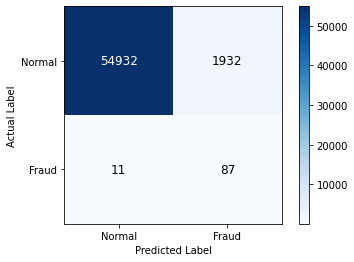

Recall: 0.8877551020408163 Precision: 0.04309063893016345 F1: 0.08219178082191782


In [39]:
#Create model with best weight parameter
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model
lr.fit(x_train_u, y_train_u) #Fitting the model

#Predict on the (skewed) test set
y_pred = lr.predict(x_test) 


#Evaluate the model
#Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
fruads = y_test[y_test == 1]
print('Actual Frauds:', len(fruads))
non_fruads = y_test[y_test == 0]
print('Actual Non-Frauds:', len(non_fruads))

#Calculate metrics
pfa = cnf_matrix[0][1]/(len(non_fruads))
print('Probability of False Alarm:', pfa)
pmd = cnf_matrix[1][0]/(len(fruads))
print('Probability of Missed Detection', pmd)
trpr = cnf_matrix[1][1]/(len(fruads))
print('True Positive Rate:', trpr)

#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()

#Precision and Recall and F1 Score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Recall:', recall, 'Precision:', precision, 'F1:', f1)


#### Model without Data Conditioning (for comparision)

Actual Frauds: 98
Actual Non-Frauds: 56864
Probability of False Alarm: 0.00019344400675295442
Probability of Missed Detection 0.35714285714285715
True Positive Rate: 0.6428571428571429


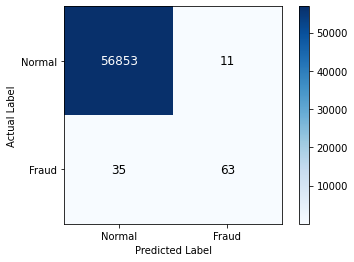

Recall: 0.6428571428571429 Precision: 0.8513513513513513 F1: 0.7325581395348839


In [40]:
#use entire (unbalanced) training and testing set to evaluate model
lr = LogisticRegression(C = c, penalty= "l2", max_iter= 500) #Logistic Regression model
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)


#Evaluate the model
#Confusion Matrix
#Evaluate the model
#Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
fruads = y_test[y_test == 1]
print('Actual Frauds:', len(fruads))
non_fruads = y_test[y_test == 0]
print('Actual Non-Frauds:', len(non_fruads))

#Calculate metrics
pfa2 = cnf_matrix[0][1]/(len(non_fruads))
print('Probability of False Alarm:', pfa2)
pmd2 = cnf_matrix[1][0]/(len(fruads))
print('Probability of Missed Detection', pmd2)
trpr2 = cnf_matrix[1][1]/(len(fruads))
print('True Positive Rate:', trpr2)

#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()

#Precision and Recall and F1 Score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Recall:', recall, 'Precision:', precision, 'F1:', f1)


#### ROC Curve for Both Models

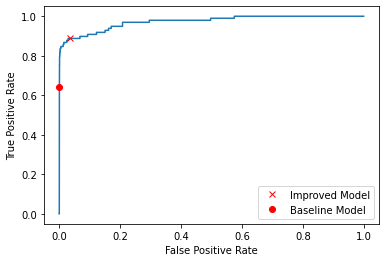

AUC: 0.9728212964983405


In [41]:
#Plot ROC curve
y_pred = lr.fit(x_train_u, y_train_u).decision_function(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False) #Can just show on 1 roc curve because it ends up being the same in both cases with just different threshold
fig = plt.figure()
plt.plot(fpr, tpr)
plt.plot(pfa,trpr, 'rx', label = "Improved Model")
plt.plot(pfa2,trpr2, 'ro', label = "Baseline Model")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC:', auc(fpr, tpr))

Plot of First Two Principal Components

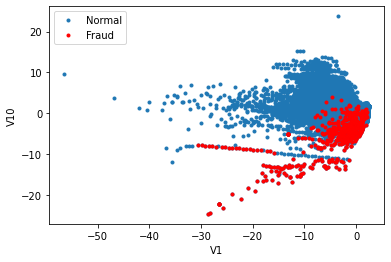

In [49]:
fraud_ix = np.argwhere(np.array(y==1))[:,0]
v1_fraud = data['V1'][fraud_ix]
v1 = data['V1']
v2_fraud = data['V2'][fraud_ix]
v2 = data['V2'] 

fig = plt.figure()
plt.plot(v1, v2, '.', label='Normal')
plt.plot(v1_fraud, v2_fraud, 'r.', label ='Fraud')

plt.xlabel('V1')
plt.ylabel('V2')
plt.legend()
plt.show()


Helpful code: https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now